In [5]:
cd ..

/Users/peabody/Documents/galvanize/capstones/strava


In [6]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from stravalib.client import Client

from src.get_strava_data import StravaAthlete

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

pd.set_option('display.max_columns', 500)

In [7]:
ath_df = pd.read_csv('data/athletes.csv') 
ride_ids = pd.read_csv('data/Feldy_Bikes/ride_ids.csv')
segments_df = pd.read_csv('data/Feldy_Bikes/segments_df.csv')
efforts_df = pd.read_csv('data/Feldy_Bikes/efforts_df.csv')
seg_details_df = pd.read_csv('data/seg_details_df.csv')

In [8]:
# kp = StravaAthlete(token = 'de05acb15a17c6dfa6008f7d6e122b328e57b228')

# kp.add_athlete()
# ath_df = kp.ath_df 

# kp.get_rides()
# ride_ids = kp.ride_ids

# kp.get_segments()
# segments_df = kp.segments_df

# kp.get_efforts()
# efforts_df = kp.efforts_df

# seg_details_df = pd.read_csv('data/seg_details_df.csv')

In [9]:
print(segments_df.bike.unique())
print(len(segments_df.bike.unique()))
print()
print('Dropping bikes with bad data...')
segments_df = segments_df[~segments_df.bike.isin(['CA Hardtail','Rented/Borrowed/Stolen '])]
print(segments_df.bike.unique())
print(len(segments_df.bike.unique()))

['Road' 'FS Trail' 'DJ' 'Road + Burley' 'Formerly Singlespeed' 'SDF-2'
 'Destro' 'Fixed' 'FatFeld' 'Galvatron' 'Carbon Road' 'Trogdor']
12

Dropping bikes with bad data...
['Road' 'FS Trail' 'DJ' 'Road + Burley' 'Formerly Singlespeed' 'SDF-2'
 'Destro' 'Fixed' 'FatFeld' 'Galvatron' 'Carbon Road' 'Trogdor']
12


In [10]:
segments_df['bike_type'] = segments_df['bike'].apply(lambda x: 'Road' if x in ['Carbon Road',
                                                                               'Road + Burley',
                                                                               'Road',
                                                                               'Fixed'] 
                                                                               else 'Mountain')
segments_by_bike = segments_df.groupby(['bike_type','bike']).count().iloc[:,1].reset_index()
segments_by_bike.rename(columns={"ride_id": "number_of_attempts"}, inplace = True)
segments_by_bike

,bike_type,bike,number_of_attempts
0,Mountain,DJ,369
1,Mountain,Destro,14030
2,Mountain,FS Trail,2120
3,Mountain,FatFeld,590
4,Mountain,Formerly Singlespeed,2554
5,Mountain,Galvatron,3502
6,Mountain,SDF-2,1015
7,Mountain,Trogdor,5470
8,Road,Carbon Road,4318
9,Road,Fixed,164


In [11]:
segments_by_bike_type = segments_df.groupby(['bike_type']).count().iloc[:,1].reset_index()
segments_by_bike_type.rename(columns={"ride_id": "number_of_attempts"}, inplace = True)
segments_by_bike_type

,bike_type,number_of_attempts
0,Mountain,29650
1,Road,28370


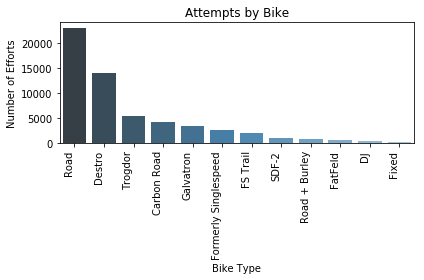

In [19]:
fig, ax = plt.subplots()
    
sns.barplot(x="bike", y = 'number_of_attempts',
            data=segments_by_bike.sort_values('number_of_attempts', axis=0, ascending=False),
            palette = 'Blues_d',
            ax=ax)
ax.set_title('Attempts by Bike')
ax.set_xlabel('Bike Type')
ax.set_ylabel('Number of Efforts')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    
plt.tight_layout()

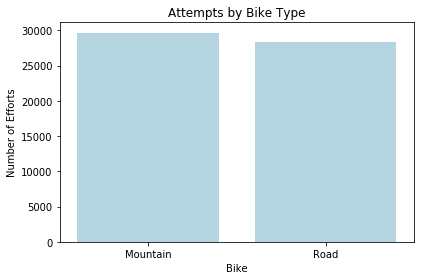

In [20]:
fig, ax = plt.subplots()

    
sns.barplot(x="bike_type", y = 'number_of_attempts', data=segments_by_bike_type, color = 'lightblue', ax=ax)
ax.set_title('Attempts by Bike Type')
ax.set_xlabel('Bike')
ax.set_ylabel('Number of Efforts')



plt.tight_layout()

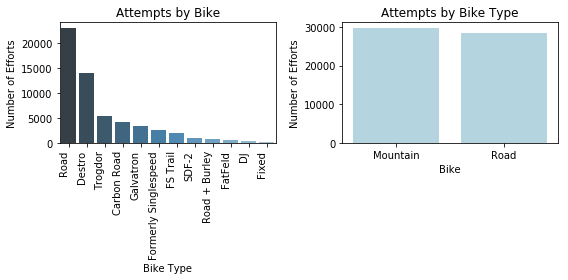

In [17]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
    
sns.barplot(x="bike", y = 'number_of_attempts',
            data=segments_by_bike.sort_values('number_of_attempts', axis=0, ascending=False),
            palette = 'Blues_d',
            ax=ax[0])
ax[0].set_title('Attempts by Bike')
ax[0].set_xlabel('Bike Type')
ax[0].set_ylabel('Number of Efforts')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha="right")
    
sns.barplot(x="bike_type", y = 'number_of_attempts', data=segments_by_bike_type, color = 'lightblue', ax=ax[1])
ax[1].set_title('Attempts by Bike Type')
ax[1].set_xlabel('Bike')
ax[1].set_ylabel('Number of Efforts')



plt.tight_layout()

''

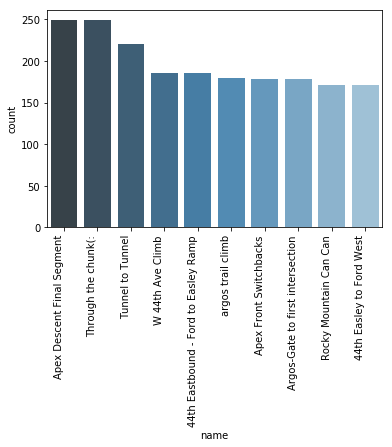

In [15]:
segment_counts = pd.DataFrame(efforts_df.groupby('segment_id').count().sort_values(by = 'name', ascending = False).iloc[:,0])
top10segs = list(segment_counts.head(10).iloc[:,0])
popular_segments = pd.DataFrame(efforts_df.groupby('segment_id').count().sort_values(by = 'name', ascending = False).iloc[:,0])
popular_segments.reset_index(inplace = True)
top10segs = list(popular_segments.head(10).iloc[:,0])

data = efforts_df[efforts_df.segment_id.isin(top10segs)]

ax = sns.countplot(x = 'name',
                    data = data, 
                    order = data.name.value_counts().index,
                    palette = 'Blues_d')
ax.set_xticklabels(plt.get_xticklabels(), rotation=90, ha="right")
;

In [234]:
temp = segments_df[['segment_id','bike_type']]
temp['percent_road'] = np.where(segments_df['bike_type']=='Road',1,0)
bike_segment = temp.groupby('segment_id').mean().reset_index()
#bike_segment.drop(['ride_id'], axis=1,inplace=True)
bike_segment['road_threshold'] = np.where(bike_segment.percent_road > .7, 1, np.where(bike_segment.percent_road < .3, 0, np.nan))
print(bike_segment.shape)
bike_segment.head()

(7628, 3)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,segment_id,percent_road,road_threshold
0,746,1.0,1.0
1,748,0.0,0.0
2,763,1.0,1.0
3,770,0.0,0.0
4,771,0.0,0.0


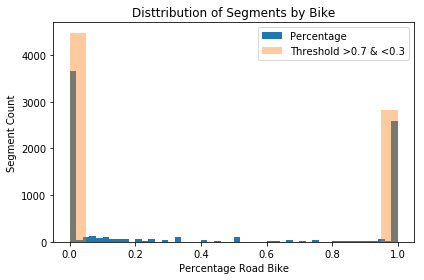

In [136]:
fig, ax = plt.subplots()

ax.hist(bike_segment.percent_road, bins = 50, label = 'Percentage')
ax.hist(bike_segment.road_threshold.dropna(), bins = 20, alpha = .4, label = 'Threshold >0.7 & <0.3')
ax.set_title('Disttribution of Segments by Bike')
ax.set_ylabel('Segment Count')
ax.set_xlabel('Percentage Road Bike')
ax.legend()

plt.tight_layout();

In [233]:
eff_seg_deats = pd.merge(efforts_df, seg_details_df, on = ['segment_id','name'], how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, segments_df.drop(['percent_road'], axis=1), on = 'segment_id', how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, bike_segment, on = 'segment_id', how = 'inner')

In [165]:
print(eff_seg_deats.shape)
eff_seg_deats.head()

(2862165, 37)


,segment_id,effort_id,name,start_date,moving_time,elapsed_time,average_heartrate,max_heartrate,distance,average_grade,maximum_grade,elevation_high,elevation_low,total_elevation_gain,start_latitude,end_latitude,start_longitude,end_longitude,climb_category,city,state,country,effort_count,athlete_count,athlete_segment_stats,map,ride_name,ride_id,bike,ride_distance,ride_moving_time,ride_elapsed_time,ride_elevation_gain,ride_start_time,bike_type,percent_road,road_threshold
0,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,0:08:13,0:08:13,NaN,NaN,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...","11/24/2012 Golden, CO",40114272,FS Trail,8.437535,0 days 01:13:00.000000000,0 days 01:13:38.000000000,1639.763832,2012-11-24 10:20:44,Mountain,0.061947,0.0
1,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,0:08:13,0:08:13,NaN,NaN,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",12/08/2012 Chimpex,40114604,FS Trail,13.028596,0 days 01:45:20.000000000,0 days 02:22:46.000000000,2434.383280,2012-12-08 13:02:47,Mountain,0.061947,0.0
2,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,0:08:13,0:08:13,NaN,NaN,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",Apex Classic,54689690,Formerly Singlespeed,6.966315,0 days 01:02:06.000000000,0 days 01:03:11.000000000,1358.267760,2013-05-16 06:15:23,Mountain,0.061947,0.0
3,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,0:08:13,0:08:13,NaN,NaN,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",Probably last hard ride before Growler,55681128,Formerly Singlespeed,7.076670,0 days 01:00:24.000000000,0 days 01:00:41.000000000,1383.202144,2013-05-22 06:13:34,Mountain,0.061947,0.0
4,649639,660391611,Enchanted forest descent,2012-07-28T14:21:34+00:00,0:08:13,0:08:13,NaN,NaN,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",Bad Day at Work,60389386,Formerly Singlespeed,8.335816,0 days 01:00:40.000000000,0 days 14:00:35.000000000,1500.656216,2013-06-14 06:07:04,Mountain,0.061947,0.0


In [140]:
#eff_seg_deats.drop_duplicates().shape

(2862165, 37)

In [166]:
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [167]:
bike_selector_df = eff_seg_deats.dropna()

In [168]:
bike_selector_df.loc[:,'moving_time'] = bike_selector_df.loc[:,'moving_time'].apply(get_sec)
bike_selector_df.loc[:,'elapsed_time'] = bike_selector_df.loc[:,'elapsed_time'].apply(get_sec)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [169]:
bike_selector_df.head()

,segment_id,effort_id,name,start_date,moving_time,elapsed_time,average_heartrate,max_heartrate,distance,average_grade,maximum_grade,elevation_high,elevation_low,total_elevation_gain,start_latitude,end_latitude,start_longitude,end_longitude,climb_category,city,state,country,effort_count,athlete_count,athlete_segment_stats,map,ride_name,ride_id,bike,ride_distance,ride_moving_time,ride_elapsed_time,ride_elevation_gain,ride_start_time,bike_type,percent_road,road_threshold
565,649639,660847697,Enchanted forest descent,2012-12-08T21:29:41+00:00,423,452,135.9,156.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...","11/24/2012 Golden, CO",40114272,FS Trail,8.437535,0 days 01:13:00.000000000,0 days 01:13:38.000000000,1639.763832,2012-11-24 10:20:44,Mountain,0.061947,0.0
566,649639,660847697,Enchanted forest descent,2012-12-08T21:29:41+00:00,423,452,135.9,156.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",12/08/2012 Chimpex,40114604,FS Trail,13.028596,0 days 01:45:20.000000000,0 days 02:22:46.000000000,2434.383280,2012-12-08 13:02:47,Mountain,0.061947,0.0
567,649639,660847697,Enchanted forest descent,2012-12-08T21:29:41+00:00,423,452,135.9,156.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",Apex Classic,54689690,Formerly Singlespeed,6.966315,0 days 01:02:06.000000000,0 days 01:03:11.000000000,1358.267760,2013-05-16 06:15:23,Mountain,0.061947,0.0
568,649639,660847697,Enchanted forest descent,2012-12-08T21:29:41+00:00,423,452,135.9,156.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",Probably last hard ride before Growler,55681128,Formerly Singlespeed,7.076670,0 days 01:00:24.000000000,0 days 01:00:41.000000000,1383.202144,2013-05-22 06:13:34,Mountain,0.061947,0.0
569,649639,660847697,Enchanted forest descent,2012-12-08T21:29:41+00:00,423,452,135.9,156.0,1948.42,-6.7,407.4,2166.0,2034.2,26.2,39.717164,39.714337,-105.248621,-105.234528,0,Golden,CO,United States,48060,8108,"{'effort_count': 124, 'pr_elapsed_time': '0:05...","{'id': 's649639', 'polyline': 'gglqF|jkaSBYCSE...",Bad Day at Work,60389386,Formerly Singlespeed,8.335816,0 days 01:00:40.000000000,0 days 14:00:35.000000000,1500.656216,2013-06-14 06:07:04,Mountain,0.061947,0.0


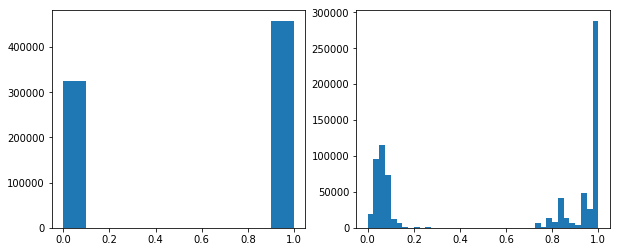

In [175]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].hist(bike_selector_df.road_threshold)
ax[1].hist(bike_selector_df.percent_road, bins = 40);

In [235]:
sample_df = bike_selector_df.sample(n=10000, random_state=1)

In [236]:
sample_df = sample_df[(sample_df.elapsed_time < 6000) & (sample_df.average_heartrate < 175)]

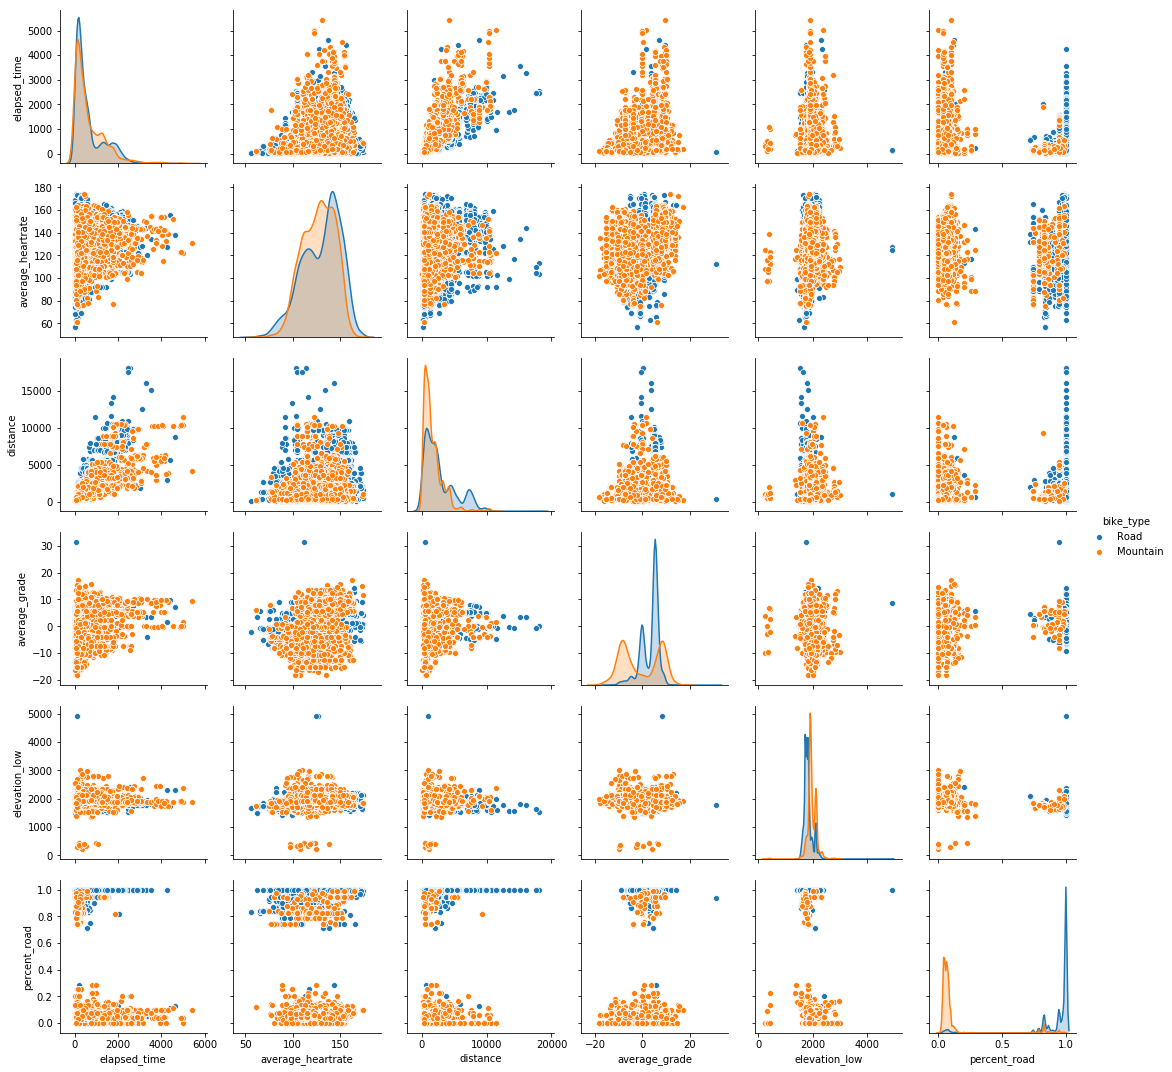

In [237]:
sns.pairplot(sample_df[['elapsed_time','average_heartrate','distance',
                        'average_grade','elevation_low','bike_type','percent_road']], hue='bike_type');

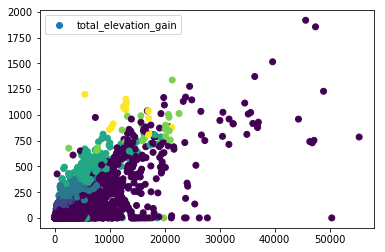

In [241]:
plt.scatter(seg_details_df.distance,seg_details_df.total_elevation_gain, c = seg_details_df.climb_category)
plt.legend()

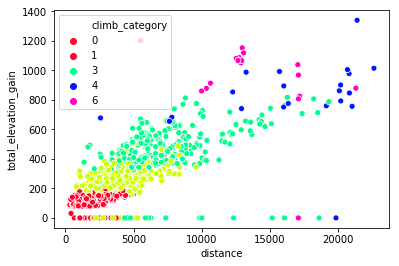

In [256]:
sns.scatterplot('distance','total_elevation_gain',
                data = seg_details_df[seg_details_df.climb_category != 0],
                                      hue = 'climb_category',palette='gist_rainbow')

In [254]:
np.max(seg_details_df.climb_category)

5